# NLP21@BGU.CS - HW1

## Michael Elhadad michael.elhadad@example.com
### NLP 2021 - HW1 (http://www.cs.bgu.ac.il/~elhadad/nlp21/hw1.html)

Nov 2020

In [1]:
# Boring preliminaries
%pylab inline
import numpy as np
import re
import itertools
import math
import string
import itertools
import matplotlib.pyplot as plt
import matplotlib
from collections import Counter
from __future__ import division

Populating the interactive namespace from numpy and matplotlib


<h2>Content</h2>

* <a href="#P1">Part 1: Language Models</a>
  * <a href="#data">1.1 Data Exploration</a>
    * <a href="#explore">1.1.1 Gathering basic statistics</a>
    * <a href="#power">1.1.2 Zipf and Power Law</a>
  * <a href="#ngram">1.2 n-gram model</a>
    * <a href="#n_parameters">1.2.1 How much memory do you expect a model to occupy?</a>
    * <a href="#train_lm">1.2.2 N-gram Word LM</a>
  * <a href="#eval">1.3 Language Model Evaluation</a>
    * <a href="#per">1.3.1 Perplexity</a>
    * <a href="#smoothing">1.3.2 Smoothing</a>
    * <a href="#overfit">1.3.3 Perplexity according to the order of the n-gram model
    * <a href="#test-lm">1.3.4 Test the best n-gram LM</a>
    * <a href="#gen">1.3.5 Generating Text using Language Models</a>
  * <a href="#nn-lm">1.4 Character language model</a>
    * <a href="#effectiveness">1.4.1 Read and Summarize</a>
    * <a href="#recipes">1.4.2 Recipes with a Character LM</a>
* <a href="#P2">Part 2: Polynomial curve fitting</a>
  * <a href="#syntheticdata">2.1 Synthetic data generation</a>
  * <a href="#curvefitting">2.2 Polynomial Curve Fitting</a>
  * <a href="#regularization">2.3 Polynomial Curve Fitting with Regularization</a>
  * <a href="#prob-regr">2.4 Probabilistic Regression Model</a>
* <a href="#P3">Part 3: Text Classification with Character RNN</a>
  * <a href="#readtut">3.1 Summarize the PyTorch Tutorial</a>
  * <a href="#newdata">3.2 Explore the Cities Dataset</a>
  * <a href="#citiesmodel">3.3 Train and Evaluate the RNN Model for Cities</a>
  * <a href="#bettercitiesmodel">3.4 (Optional) Improve the Model</a>

<hr>
<a name="P1"></a>
<h2>Part 1: Language Models</h2>

<a name="data"></a>
<h3>1.1 Data Exploration</h3>

<a name="explore"></a>
<h4>1.1.1 Gathering Basic Statistics</h4>

In this section, we collect and plot the following information on a text dataset:
<ul>
<li>The total number of tokens</li>
<li>The total number of characters</li>
<li>The total number of distinct words (vocabulary)</li>
<li>The total number of tokens corresponding to the top-N most frequent words in the vocabulary</li>
<li>The token/type ratio in the dataset</li>
<li>The number of types that appear in the dev data but not the training data</li>
<li>The average number and standard deviation of characters per token</li>
<li>The total number of distinct n-grams (of words) that appear in the dataset for n=2,3,4.</li>
<li>The total number of distint n-grams of characters that appear for n=2,3,4,5,6,7.</li>
</ul>

We operate on the PTB dataset, which contains 929k training words, 73k validation words, and 82k test words. 
It is formatted in such a way that only the top 10k most frequent words are in its vocabulary.

We gather the files from <a href="http://www.fit.vutbr.cz/~imikolov/rnnlm/simple-examples.tgz">the dataset</a>
where sentences are segmented one per line and words separated by spaces.  We assume the files are located in "../data/".

#### Tokenizing

You may need to tokenize strings read from the dataset files into lists of tokens.  

Think which method is best appropriate for this dataset given the way it is formatting.
Recall the method based on regular expressions used in Norvig's piece.
Compare it with the the tokenizer provided in the nltk library.

In [2]:
import nltk

text = "We're 2 men trying to tokenize 1-long sentence, the way PTB expects it."
tokens = nltk.word_tokenize(text)
print(tokens)
print("We found %s tokens using nltk" % (len(tokens)))

tokens = re.findall(r'\w+', text.lower())
print(tokens)
print("We found %s tokens using Norvig's regex" % (len(text.split())))

print("None of the options are good enough, but nltk is close, so we'll use it to write our own tokenize")
def tokenize_with_spaces(text):
    tokens = nltk.word_tokenize(text.lower().replace(" ", " Space "))
    tokens = [t for t in tokens if re.match(r'.*[a-z0-9]+.*', t)]
    tokens = ['N' if re.fullmatch(r'[0-9]+', t) else t for t in tokens]
    return tokens

def tokenize_words(text):
    return [t for t in tokenize_with_spaces(text) if t!='Space']

tokens = tokenize_words(text)
print(tokens)
assert ['we', "'re", 'N', 'men', 'trying', 'to', 'tokenize', '1-long', 'sentence', 'the', 'way', 'ptb', 'expects', 'it']
print("We found %s tokens using out own tokenizing" % (len(tokens)))
print("Yep, seems pretty good")

print("Now we will tokenize to chars")
def tokenize_chars(tokens):
    return list(itertools.chain(*(list('_' if t=='Space' else t) for t in tokenize_with_spaces(text))))[:-1]
print(tokenize_chars(text))
assert tokenize_chars(text)==['w', 'e', "'", 'r', 'e', '_', 'N', '_', 'm', 'e', 'n', '_', 't', 'r', 'y', 'i', 'n', 'g', '_', 't', 'o', '_', 't', 'o', 'k', 'e', 'n', 'i', 'z', 'e', '_', '1', '-', 'l', 'o', 'n', 'g', '_', 's', 'e', 'n', 't', 'e', 'n', 'c', 'e', '_', 't', 'h', 'e', '_', 'w', 'a', 'y', '_', 'p', 't', 'b', '_', 'e', 'x', 'p', 'e', 'c', 't', 's', '_', 'i']
print("Got it...")

['We', "'re", '2', 'men', 'trying', 'to', 'tokenize', '1-long', 'sentence', ',', 'the', 'way', 'PTB', 'expects', 'it', '.']
We found 16 tokens using nltk
['we', 're', '2', 'men', 'trying', 'to', 'tokenize', '1', 'long', 'sentence', 'the', 'way', 'ptb', 'expects', 'it']
We found 13 tokens using Norvig's regex
None of the options are good enough, but nltk is close, so we'll use it to write our own tokenize
['we', "'re", 'N', 'men', 'trying', 'to', 'tokenize', '1-long', 'sentence', 'the', 'way', 'ptb', 'expects', 'it']
We found 14 tokens using out own tokenizing
Yep, seems pretty good
Now we will tokenize to chars
['w', 'e', "'", 'r', 'e', '_', 'N', '_', 'm', 'e', 'n', '_', 't', 'r', 'y', 'i', 'n', 'g', '_', 't', 'o', '_', 't', 'o', 'k', 'e', 'n', 'i', 'z', 'e', '_', '1', '-', 'l', 'o', 'n', 'g', '_', 's', 'e', 'n', 't', 'e', 'n', 'c', 'e', '_', 't', 'h', 'e', '_', 'w', 'a', 'y', '_', 'p', 't', 'b', '_', 'e', 'x', 'p', 'e', 'c', 't', 's', '_', 'i']
Got it...


The output of justext is organized in paragraphs.  We converted them as one line of text each.

Note how abbreviations in English are tokenized in PTB ("I'm" becomes ["i", "'m"]) and numbersare all replaced by the "N" special token.

#### Loading Data

In [3]:
def tokenize_ptb(text):
    return [t for t in text.split(' ') if t!='']

with open("../data/shakespeare_input.txt", "r") as f:
    ext_test_text = f.read()
ext_test_tokens = tokenize_words(ext_test_text)
with open("../data/ptb/data/ptb.train.txt", "r") as f:
    train_text = f.read()
train_tokens = tokenize_ptb(train_text)
with open("../data/ptb/data/ptb.valid.txt", "r") as f:
    dev_text = f.read()
dev_tokens = tokenize_ptb(dev_text)
with open("../data/ptb/data/ptb.test.txt", "r") as f:
    test_text = f.read()
test_tokens = tokenize_ptb(test_text)
with open("../data/ptb/data/ptb.char.train.txt", "r") as f:
    train_char_tokens = tokenize_ptb(f.read())


<b> Let's first collect and plot basic information about the dataset </b>

In [4]:
tokens = train_tokens
# The total number of tokens
print(f'We expect 929k tokens, result is {len(tokens)}')
print("Yep, that's what we got")

We expect 929k tokens, result is 929589
Yep, that's what we got


In [5]:
# The total number of characters tokens
print(f"We expect each word to have lentgh 5 on average, plus 1 space between words, so we expect {6*len(tokens)} char tokens")
print(f'Result is {len(train_char_tokens)}, pretty close')

We expect each word to have lentgh 5 on average, plus 1 space between words, so we expect 5577534 char tokens
Result is 5017482, pretty close


In [6]:
# The total number of distinct words (vocabulary)
print("We expect the vocabulary size to be 10000, since that's the way the dataset was constructed")
print(f'Result is {len(set(tokens))}, exactly what we tought')

We expect the vocabulary size to be 10000, since that's the way the dataset was constructed
Result is 10000, exactly what we tought


We expect number of tokens corresponding to the top-N most frequent words to go by Zipf's law,
which means that for example the first word is expected 94976.13579629657 times, and the second word half of that.
We will disregrad <unk> for that matter
[('the', 50770), ('\n', 42068), ('N', 32481), ('of', 24400), ('to', 23638), ('a', 21196), ('in', 18000), ('and', 17474), ("'s", 9784), ('that', 8931), ('for', 8927), ('$', 7541), ('is', 7337), ('it', 6112), ('said', 6027), ('on', 5650), ('by', 4915), ('at', 4894), ('as', 4833), ('from', 4724)]
Results are not suprising, the plot is almost linear, exaclty as Zipf's law anticipates


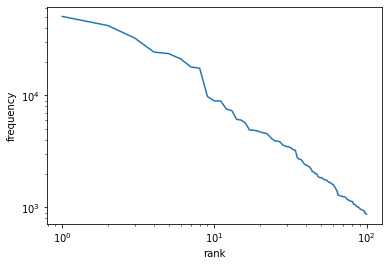

In [7]:
# The total number of tokens corresponding to the top-N most frequent words in the vocabulary
summ = 0
for i in range(len(set(tokens))):
    summ += 1/(i+1)
print(f"""We expect number of tokens corresponding to the top-N most frequent words to go by Zipf's law,
which means that for example the first word is expected {len(tokens)/summ} times, and the second word half of that.
We will disregrad <unk> for that matter""")
corpus_counts = Counter(tokens)
del corpus_counts['<unk>']
print(corpus_counts.most_common(20))
plt.loglog(np.arange(1, 101), [val for word,val in corpus_counts.most_common(100)])
plt.xlabel('rank')
plt.ylabel('frequency')
print("Results are not suprising, the plot is almost linear, exaclty as Zipf's law anticipates")

In [8]:
# The token/type ratio in the dataset
print(f'token/type ratio in the dataset is {len(tokens)/len(set(tokens))} (no guess, since we already had both numbers)')

token/type ratio in the dataset is 92.9589 (no guess, since we already had both numbers)


In [9]:
# The number of types that appear in the dev data but not the training data (hint: use sets which are a primitive dataset in Python for this)
print(f"""We expect number of types that appear in the dev data but not the training data to be 0, since that's how the dataset was generated, taking the top 9999 words, and changing the rest to <unk>. result is {len(set(dev_tokens)-set(tokens))}""")

We expect number of types that appear in the dev data but not the training data to be 0, since that's how the dataset was generated, taking the top 9999 words, and changing the rest to <unk>. result is 0


In [10]:
# The average number and standard deviation of characters per token
print(f"""As we said earlier, we expected each token to have 5 chars on avergae, 
we will now change out estimation to 4.5 according to the previous results, with standard deviation of about 3""")
lengths = list(map(lambda t: len(t), tokens))
print(f"Results are that the average number of chars per token is {np.mean(lengths)} with std of {np.std(lengths)}, pretty good estimations")

As we said earlier, we expected each token to have 5 chars on avergae, 
we will now change out estimation to 4.5 according to the previous results, with standard deviation of about 3
Results are that the average number of chars per token is 4.488036110582204 with std of 2.653352058785631, pretty good estimations


In [11]:
# The total number of distinct n-grams (of words) that appear in the dataset for n=2,3,4.
print(f"We will now show number of distinct n-grams for n=2,3,4")
print(f"We expect about 200K bi-grams, since the unigram model is quite weak in general, and then it should converge towards {len(tokens)} (the number of tokens) very quickly")
n_gram_count = {}
n_gram_count[1] = len(set(tokens))
for n in range (2, 6):
    n_gram_count[n] = len(set(tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)))
    print(f"For n={n} we got {n_gram_count[n]}")
print(f"""Results are not suprising, dataset is relatively small, so we might have a huge generalization problem with 3-gram language model and above""")

We will now show number of distinct n-grams for n=2,3,4
We expect about 200K bi-grams, since the unigram model is quite weak in general, and then it should converge towards 929589 (the number of tokens) very quickly
For n=2 we got 264989
For n=3 we got 615128
For n=4 we got 792627
For n=5 we got 857994
Results are not suprising, dataset is relatively small, so we might have a huge generalization problem with 3-gram language model and above


In [12]:
# The total number of distint n-grams of characters that appear for n=2,3,4,5,6,7.
print(f"We will now show number of distinct charachters n-grams for n=2,3,4,5,6,7")
print(f"We expect about {30*30} bi-grams, from there it will grow with the ratio between n-gram and (n-1)-gram getting lower.")
char_n_gram_count = {}
char_n_gram_count[1] = len(set(train_char_tokens))
for n in range (2, 8):
    char_n_gram_count[n] = len(set(tuple(train_char_tokens[i:i+n]) for i in range(len(train_char_tokens)-n+1)))
    print(f"For n={n} we got {char_n_gram_count[n]}, ratio of {char_n_gram_count[n]/char_n_gram_count[n-1]}")
print(f"Results are great, got as expected")

We will now show number of distinct charachters n-grams for n=2,3,4,5,6,7
We expect about 900 bi-grams, from there it will grow with the ratio between n-gram and (n-1)-gram getting lower.
For n=2 we got 841, ratio of 16.82
For n=3 we got 7492, ratio of 8.90844233055886
For n=4 we got 37957, ratio of 5.066337426588361
For n=5 we got 133865, ratio of 3.5267539584266405
For n=6 we got 344650, ratio of 2.57460874761887
For n=7 we got 674859, ratio of 1.9580995212534456
Results are great, got as expected


<a name="power"></a>
<h4>1.1.2 Zipf and Power Law</h4>

Word count distributions are said to follow <a href="https://en.wikipedia.org/wiki/Power_law">power law distributions</a>. 
In practice, this means that a plot of the log-frequency against the log-rank is nearly linear. 
We will verify that this holds for the Penn Treebank dataset by constructing the appropriate corpus_counts counter:


[-0.97515322 11.37868322]
The power law holds for the PTB dataset for the large number of occurences, small values do not fit the trendline


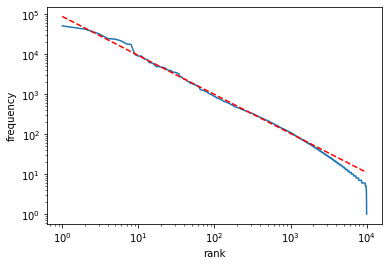

In [13]:
counts = np.array([val for word,val in corpus_counts.most_common()])

# Fixing to start from index 1 instead of zero
plt.loglog(np.arange(1, len(counts)+1), counts)
plt.xlabel('rank')
plt.ylabel('frequency')

# Fitting a trendline without words without small number of occurences
FIT_N = 2000
z = numpy.polyfit(np.log(np.arange(1, FIT_N+1)), np.log(counts[:FIT_N]), 1)
print(z)
p = numpy.poly1d(z)
plt.loglog(np.arange(1, len(counts)+1), np.exp(p(np.log(np.arange(1, len(counts)+1)))) ,"r--")

print("The power law holds for the PTB dataset for the large number of occurences, small values do not fit the trendline")

<a name="ngram"></a>
<h3><a name="ngram">1.2 n-gram Word Language Model</a></h3>

<a name="n_parameters"></a>
<h4>1.2.1 How much memory do you expect a model to occupy?</h4>


<b> Using n-gram model, the number of parameters we will equals to in theory to the number of unique words in the vocabulary ^ n+1. However, most of them would not occur at all in our database. Because of that, using a sparse representaion, the number of actual parameters might equate to the number of (n+1)-grams + n-grams For example for n=2, we would need p(w3|w1w2) for all found sequences w1w2w3, and one more for p(unkonwn|w1w2). 
By assigning an integer value for each word, we would need k=log(number of unique words) bits to represnt them (with extra 4.65 bytes for each for the translations), in addition (n+1)*k bits to represnt the sequences of the first kind, and n*k to represnt the sequences of the second kind, and in addition 64 bits for each one of them to represent the probabilties using floats. </b>

In [14]:
def get_model_size(n):
    res = 0
    k = np.log(n_gram_count[1])
    res += (k+4.65)*n_gram_count[1]
    res += ((n+1)*k+8)*n_gram_count[n+1]
    res += (n*k+8)*n_gram_count[n]
    return res
print("We will now estimate the memory out n-gram language word model will occupy")
for i in range(1, 5):
    print(f"For n={i} that equates {get_model_size(i)/8} bytes for the representaion")
print(f"""This is of course a a sparse minimal representation, if we are not careful, 
we would need the number of uniqe words ^ n+1 parameters for an n-gram model""")

We will now estimate the memory out n-gram language word model will occupy
For n=1 that equates 913987.0721373396 bytes for the representaion
For n=2 that equates 3632178.9912972315 bytes for the representaion
For n=3 that equates 7199839.499099015 bytes for the representaion
For n=4 that equates 10257139.140169987 bytes for the representaion
This is of course a a sparse minimal representation, if we are not careful, 
we would need the number of uniqe words ^ n+1 parameters for an n-gram model


<a name="train_lm"></a>
<h4>1.2.2 N-gram LM</h4>

We present a Python function to construct a word n-gram model given a dataset according to the signature:
<pre>
train_word_lm(dataset, n=2)
</pre>

In [15]:
word_to_hist = lambda t: tuple(t)
word_to_token = lambda t: [t]

def train_word_lm(fname, n=2):
    return create_word_lm(fname, n)

def create_word_lm(fname, order=2):
    with open(fname) as f:
        data = f.read()
    data = tokenize_ptb(data)
    return create_lm_generic(data, order=order, to_token=word_to_token, to_hist=word_to_hist)

def create_letter_lm(fname, order=4):
    with open(fname) as f:
        data = f.read()
    data = data.replace(' ','')
    return create_lm_generic(data, order=order)

def create_lm_generic(data, order=4, to_token = lambda t: t, to_hist = lambda t: t):
    pad = to_token('*') * order
    data = pad + data
    cfd = nltk.ConditionalFreqDist((to_hist(data[i : i + order]), data[i + order]) for i in range(len(data) - order))
    cpd = nltk.ConditionalProbDist(cfd, nltk.MLEProbDist)
    return cpd, cfd

def test_create_letter_lm(order = 4):
    return create_letter_lm('../data/ptb/data/ptb.char.train.txt', order)

def test_create_word_lm(order = 2):
    return create_word_lm('../data/ptb/data/ptb.train.txt', order)

def test_generate_from_lm(lm, order = 4, to_token = lambda t: t, to_hist = lambda t: t):
    out = []
    hist = to_hist(to_token('*') * order)
    for _ in range(1000):
        token = lm[hist].generate()
        hist = hist[1:] + to_hist(to_token(token))
        out.append(token)
    return out
    

lm, cfd = test_create_word_lm(2)
out = test_generate_from_lm(lm, order = 2, to_token=word_to_token, to_hist=word_to_hist)

# lm, cfd = test_create_letter_lm(4)
# out = test_generate_from_lm(lm, order = 4)

print(' '.join(out[:50]))

aer banknote berlitz calloway centrust cluett fromstein gitano guterman hydro-quebec ipo kia memotec mlx nahb punts rake regatta rubens sim snack-food ssangyong swapo wachter 
 pierre <unk> N speech 
 according to people familiar with the u.s. supreme court of appeals in new york where viacom in may filed a


* The only function that is unique to ConditionalProbDist is conditions, otherwise all dict fuctions are available. However, by accessing a specific key, we get a ditribution object, and then there are many more useful functions.

Here is a list of useful fuctions for language model in this context:
1. conditions(self) - Return all the n-grams the model has
2. prob(self, sample) - Return the probability for a given sample.
3. logprob(self, sample) - Return the base 2 logarithm probability for a given sample.
4. max(self) -  Return the sample with the greatest probability.
5. samples(self) -  Return a list of all samples with nonzero probability
6. discount(self) - Return the ratio by which counts are discounted on average. In our case of a model with no regularization, that amounts to zero.
7. generate(self) -  Return a randomly selected sample from the probability distribution. 

* Explain how the function generate() used in the sample works - why does it compute a correct way to sample from a distribution?
The way the function generate() used in the smaple works, is by converting the probabilities to cummulative probabilities (the order does not matter in this process), then generating a random number, and getting the sample that related to that cummulative probabilty.

It is equivalent to:

In [16]:
import random
hist = ('we', 'have')
samples = list(lm[hist].samples())
weights = []
for s in samples:
    weights.append(lm[hist].prob(s))
token = random.choices(samples, weights=weights, k=1)
print(token)

['ways']


<a name="eval"></a>
<h3>1.3 Language Model Evaluation</h3>

We now evaluate the performance of the learned language models by using two techniques:
measuring perplexity on a validation dataset and using the model to generate random text, then assessing
the readability of the generated text.

<a name="per"></a>
<h4>1.3.1 Perplexity</h4>

We implement a Python function to measure the perplexity of a trained model on a test dataset.

We adapt the methods to compute the cross-entropy and perplexity of a model from nltk.model
to our implementation

<b> 
For the purpose of the peprlexity of the model, we use here a slightly different version of the model, that only in case the condition is not found on the model (which means the n-gram was not on the training dataset), a random token amongs all trained condition is taken
This should be implemented on the generation too if not starting from an empty seed! 

This is not smoothing per se, because we only do it for undefined marginal distribution, so we may still get an infinity perplexity as we will see.
A better model would revert back in these cases to a smaller n-gram model, or even ensemble them to begin with (with constant weights, or weights that depends on the sample size)
    
As Prof. Michael Elhadad suggested, we have read the article Sparse Text Generation by P.H. Martin et al.: https://arxiv.org/pdf/2004.02644.pdf
As it was written in the article, epsilon-perplexity is another way to correct for zero probabilty, we would argue however that it constructs a new language model which is the Laplace smoothing of the original model, so we decided to keep things as they are.
</b>

In [17]:
def perplexity(lm, data, to_token = lambda t: t, to_hist = lambda t: t):
    conds = set(lm.conditions())
    n = len(next(iter(conds)))
    all_samples_len = len(set().union(*[lm[c].samples() for c in conds]))
    pad = to_token('*') * n
    data = pad + data
    hist = to_hist(pad)
    summ = 0
    for token in data[n:]:
        if hist in conds:
            summ -= lm[hist].logprob(token)
        else:
            summ -= np.log(1/all_samples_len)
        hist = hist[1:] + to_hist(to_token(token))
    summ /= len(data)-n
    return np.power(2, summ)
print(f"Peprlexity of train set is {perplexity(lm, train_tokens, to_token=word_to_token, to_hist=word_to_hist)}")

def perplexity_simple(lm, data):
    summ = 0
    for token in data:
        print(lm.logprob(token))
        summ += lm.logprob(token)
    summ /= -len(data)
    return np.power(2, summ)

def test_perplexity():
    samples = list(range(10))
    lm = nltk.probability.UniformProbDist(samples)
    perp = perplexity_simple(lm, samples)
    print(perp)
    assert abs(perp - len(samples)) < 0.0001

Peprlexity of train set is 7.093493436608496


In [18]:
# We now measure the reported perplexity values on the Penn Treebank validation dataset ptb.valid.txt
print(f"Peprlexity of validation set is {perplexity(lm, dev_tokens, to_token=word_to_token, to_hist=word_to_hist)}")

Peprlexity of validation set is inf


<ipython-input-17-9cf6b36f5c15>:21: RuntimeWarning: overflow encountered in power
  return np.power(2, summ)


What happens here,is that we did not do any smoothing, so new encountered word on the validation set (even conditional on a given n-gram and not completey new on the corpus) was given a probablity zero.
The perplexity is undefined in that case (or equivalent to infinity).
On the training set, the preplexity more represents the dataset itself, rather thn the model, in fact if we use high enough n such that each n-gram would show up exactly once, we would get a perplexity of exacly one for the training set...

<a name="smoothing"></a>
<h4>1.3.2 Smoothing</h4>

In order to improve the model, we will use a smoothing technique.

We use the <a href="http://www.nltk.org/_modules/nltk/probability.html">nltk probability distribution</a> module which provides different estimators that implement smoothing methods (Laplace, Lidstone, Witten-Bell, Good-Turing). 

In [19]:
# We change the model to use a different estimator than the Maximum Likelihood Estimator (MLE) count-based estimator
# to compute the probability of p(w|history).  

def create_word_lm(fname, order=2, estimator=None, **factory_kw_args):
    with open(fname) as f:
        data = f.read()
    data = tokenize_ptb(data)
    return create_lm_generic(data, order=order, to_token=word_to_token, to_hist=word_to_hist,
                             estimator=estimator, **factory_kw_args)

def create_lm_generic(data, order=4, to_token = lambda t: t, to_hist = lambda t: t, 
                      estimator=None, **factory_kw_args):
    if not estimator:
        estimator = nltk.MLEProbDist
    pad = to_token('*') * order
    data = pad + data
    cfd = nltk.ConditionalFreqDist((to_hist(data[i : i + order]), data[i + order]) for i in range(len(data) - order))
    cpd = nltk.ConditionalProbDist(cfd, estimator, **factory_kw_args)
    return cpd, cfd

def test_create_word_lm(order = 2, estimator=None, **factory_kw_args):
    return create_word_lm('../data/ptb/data/ptb.train.txt', order, estimator, **factory_kw_args)

# Sanity test - this is equivalent to an MLE estimator
lm, cfd = test_create_word_lm(2, estimator=nltk.LidstoneProbDist, gamma=0)
out = test_generate_from_lm(lm, order = 2, to_token=word_to_token, to_hist=word_to_hist)
print(' '.join(out[:50]))

aer banknote berlitz calloway centrust cluett fromstein gitano guterman hydro-quebec ipo kia memotec mlx nahb punts rake regatta rubens sim snack-food ssangyong swapo wachter 
 pierre <unk> N a share a year earlier 
 <unk> fax from david <unk> chairman of the <unk> office workers organization that supports the government


Compare the obtained perplexity of the trained model on the validation dataset for different Lidstone estimators for a 
variety of hyper-parameter gamma $0 \leq gamma \leq 1$ by drawing a graph of the obtained perplexity on the validation dataset for different values of gamma.

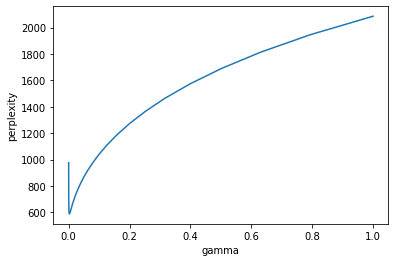

In [20]:
# Graph of perplexity of bigram LM for values of gamma with Lidstone estimator as smoothing method
def find_best_gamma(cfd, dev_data, to_token = lambda t: t, to_hist = lambda t: t):
    loggammas = np.arange(-4, 0.05, 0.1)
    perps = np.empty(len(loggammas))
    minn = float('inf')
    best = None
    # We will just use number of different tokens, since that's the worst case according to the way
    # the dataset was constructed
    for i, loggamma in enumerate(loggammas):
        # Optimiztion - using the same cfd without recalculating it
        lm = nltk.ConditionalProbDist(cfd, nltk.LidstoneProbDist, gamma=10**loggamma, bins=len(set(tokens)))
        perps[i] = perplexity(lm, dev_data, to_token, to_hist)
        if perps[i] < minn:
            minn = perps[i]
            best = (lm, 10**loggamma)
    plt.plot(10**loggammas, perps)
    plt.xlabel('gamma')
    plt.ylabel('perplexity')
    return best
lm, GG = find_best_gamma(cfd, dev_tokens, to_token=word_to_token, to_hist=word_to_hist)


In [21]:
print(f"best gamma is {GG}")
print(f"Validation peprlexity is {perplexity(lm, dev_tokens,to_token=word_to_token, to_hist=word_to_hist)}")

best gamma is 0.0025118864315095872
Validation peprlexity is 588.8667665387958


<a name="overfit"></a>
<h4>1.3.3 Perplexity according to the order of the n-gram model</h4>

Another way to improve the model is to use an n-gram model with increasing values of n (2,3,...10).

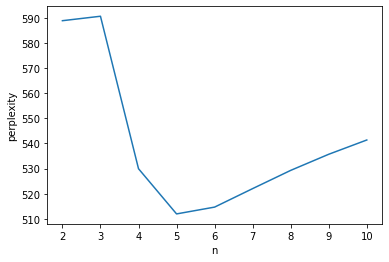

In [22]:
# Draw a graph of the obtained perplexity on the validation dataset for different values of n between 2 and 10
# for the best value of gamma obtained above.
def find_best_n(train_data, dev_data, to_token = lambda t: t, to_hist = lambda t: t):
    ns = np.arange(2, 11)
    perps = np.empty(len(ns))
    minn = float('inf')
    best = None
    # We will just use number of different tokens, since that's the worst case according to the way
    # the dataset was constructed
    for i, n in enumerate(ns):
        lm, _ = create_lm_generic(train_data, order=n, to_token=to_token, to_hist=to_hist,
                                  estimator=nltk.LidstoneProbDist, gamma=GG, bins=len(set(tokens)))
        perps[i] = perplexity(lm, dev_data, to_token, to_hist)
        if perps[i] < minn:
            minn = perps[i]
            best = (lm, n)
    plt.plot(ns, perps)
    plt.xlabel('n')
    plt.ylabel('perplexity')
    return best
lm, NN = find_best_n(train_tokens, dev_tokens, to_token=word_to_token, to_hist=word_to_hist)


In [23]:
print(f"best n is {NN}")
print(f"Validation peprlexity is {perplexity(lm, dev_tokens,to_token=word_to_token, to_hist=word_to_hist)}")

best n is 5
Validation peprlexity is 511.94943548409833


<a name="test-lm"></a>
<h4>1.3.4 Test the best n-gram LM</h4>

Based on the 2 graphs above, we hypothesize that the best combination LM is an n-gram of order 2 smoothed with Lidstone estimator with parameter gamma = 0.0025.

We test this model on the test dataset of the Penn Treebank and report the test set perpexity

In [24]:
## Test LM with optimal parameters - report perplexity on test.
best_lm, _ = create_lm_generic(train_tokens, order=2, to_token=word_to_token, to_hist=word_to_hist,
                               estimator=nltk.LidstoneProbDist, gamma=0.0025, bins=len(set(tokens)))
print(f"Test peprlexity is {perplexity(lm, test_tokens, to_token=word_to_token, to_hist=word_to_hist)}")



Test peprlexity is 544.9913217884003


<b> That seems good, we got almost the same results on the validation and test sets </b>

We also test our n-gram model with the <a href="https://www.nltk.org/api/nltk.html#nltk.probability.SimpleGoodTuringProbDist">Good-Turing estimator instead of the Lidstone estimator.

In [25]:
## Test LM with Good-Turing estimator - report perplexity.
lm, _ = create_lm_generic(train_tokens, order=2, to_token=word_to_token, to_hist=word_to_hist,
                          estimator=nltk.SimpleGoodTuringProbDist)
print(f"Test peprlexity is {perplexity(lm, test_tokens, to_token=word_to_token, to_hist=word_to_hist)}")
print(f"Unfortunately Good-Turing smoothing is not enough here")


/home/amir/anaconda3/envs/NLP/lib/python3.8/site-packages/nltk/probability.py:1456: UserWarning: SimpleGoodTuring did not find a proper best fit line for smoothing probabilities of occurrences. The probability estimates are likely to be unreliable.
  warnings.warn(


Test peprlexity is inf
Unfortunately Good-Turing smoothing is not enough here


<ipython-input-17-9cf6b36f5c15>:21: RuntimeWarning: overflow encountered in power
  return np.power(2, summ)


### To assess the success of these LMs, we compare our result with a set of baselines

1. The expected results on a uniform distribution of words (worst case): 

    The expected worst case result for a uniform distribution, the perplexity should be 10000, the size of the corpus

2. recent research results reported in research paper on language models that we have find in Google Scholar tested on the Penn Treebank dataset:

    In a paper published by Tom B. Brown et al. from OpenAI, by using GPT-3 model with few-shot learning, a preplexity of 20.5 was achieved:
https://arxiv.org/pdf/2005.14165v4.pdf

    Without using extra data, in a paper published by Chenguang Wang et al. from AWS, a preplexity of 31.3 was achieved using a BERT-Large-CAS model:
https://arxiv.org/pdf/1904.09408v2.pdf

<a name="gen"></a>
<h4>1.3.5 Generating Text from a Language Model</h4>

Another way to evaluate a language model is to use the model in a generative manner - that is, to randomly sample
sentences starting from a seed prefix, and generating each next word by sampling from the model distribution $p(w | prefix)$.

<b> We can use model[hist].generate() of course, but we were asked to implement it on our own to our understanding </b>

Discuss ways to decide when the generation should stop.

In [26]:
import random

def generate(model, seed=10):
    n = len(model.conditions()[0])
    random.seed(seed)
    out = []
    hist = tuple(['*'] * n)
    sentences = 5
    for _ in range(sentences):
        token = 'Not \n'
        while token[0]!='\n':
            samples = list(model[hist].samples())
            weights = []
            for s in samples:
                weights.append(model[hist].prob(s))
            token = random.choices(samples, weights=weights, k=1)
            hist = hist[1:] + tuple(token)
            out.append(token[0])
    return out

A good stopping mechaism would be to have a stopping token on the language model.
Fortunately, we do have one - '\n', so we will use it, and wait for it a set number of times.
The model could then naturally generate this stopping token in a place where it fits.

In [27]:
# Test generate it on the best model trained above
print(' '.join(generate(best_lm)))

aer banknote berlitz calloway centrust cluett fromstein gitano guterman hydro-quebec ipo kia memotec mlx nahb punts rake regatta rubens sim snack-food ssangyong swapo wachter 
 pierre peladeau a canadian embassy official in houston already has all but <unk> 's calculations 
 on tuesday the shares because he 's got to get around any attempt at improvements in operating margins while acquiring a foreign entity 
 freeport-mcmoran a new issue <unk> by moody 's said it had a loss for the soviet union by an average of $ N million 
 last year 's <unk> desire for oat bran it will take other steps necessary to accommodate and will pay for everyone else in the spring of N million from bankruptcy proceedings began tuesday in candlestick park is expected to profit from the reversal came after officials said apparently because the government 's massive earthquake although traders rushed to buy the sugar the analyst 



When we sample from the LM given a history, we do not pick the most likely word generated by the LM, otherwise the generator would be deterministic.  Instead, we use <a href="https://www.nltk.org/api/nltk.html#nltk.probability.ProbDistI.generate">nltk.ProbDistI.generate()</a>.  
#### Explain what is expected from this method of text generation.

It is expected that it would sample from the probablity distribution according the the probabilities

We experiment with a variety of seeds.  

In [28]:
# Test generate it on the best model trained above
for seed in range(10,15):
    print(' '.join(generate(best_lm,seed=seed)))

aer banknote berlitz calloway centrust cluett fromstein gitano guterman hydro-quebec ipo kia memotec mlx nahb punts rake regatta rubens sim snack-food ssangyong swapo wachter 
 pierre peladeau a canadian embassy official in houston already has all but <unk> 's calculations 
 on tuesday the shares because he 's got to get around any attempt at improvements in operating margins while acquiring a foreign entity 
 freeport-mcmoran a new issue <unk> by moody 's said it had a loss for the soviet union by an average of $ N million 
 last year 's <unk> desire for oat bran it will take other steps necessary to accommodate and will pay for everyone else in the spring of N million from bankruptcy proceedings began tuesday in candlestick park is expected to profit from the reversal came after officials said apparently because the government 's massive earthquake although traders rushed to buy the sugar the analyst 

aer banknote berlitz calloway centrust cluett fromstein gitano guterman hydro-queb

Analyze your observations:

<b> Our model treats the first sentince differently, an important improvemnt would be padding each new sentnece with that same padding as the first, since this dataset has no order between sentences. 
Another key observation is that the senteces don't make any sense... It means that the model doesn't capture either the sematics and the correct sytnax.
There is obviously a lot of room for improvement with more advanced algorithms. </b>

<h4>Optional material</h4>

One way to control the variety of the text generated by an LM is to introduce a parameter called the <i>temperature</i>
of the generator which allows us to sample words randomly according to the distribution produced by the LM (that is, we do not 
always select the most likely candidate - we sample from the distribution produced by the LM).  
    
<a href="https://nlp.stanford.edu/blog/maximum-likelihood-decoding-with-rnns-the-good-the-bad-and-the-ugly/">Maximum Likelihood Decoding with RNNs - the good, the bad, and the ugly</a> by Russell Stewart (2016) explains how a temperature argument can control the level of variability generated by the model.  

<b> The idea is that when we have a LM, we have some variability which comes from the model's distribution. We sometimes want to lower the variabilty in order to have more stable, and in most cases more grammatically correct output. We can do that by a function that "stretches" th distribution to the sides (in a way that high probabilities will be higher, and low ones will be lower), for example the freezing function from the article, with temperature less than 1. However, if we combine mutiple words into one category (for exampe , and treating them as one unit, they might be stretched up and not down. That phenomena may suggest that we create a bias towards less variable categories. In practice using this 2-stage temperature control was shown to improve the performance of the output, as rated by humans (there is no well defined mathematical calculation to the improvement, since the whole temperature control actually ruins the perplexty of the model) </b>

The code in <a href="https://github.com/sameersingh/uci-statnlp/blob/master/hw2/generator.py">generator.py</a> from Sameer Sing demonstrates a method to generate from a LM with a temperature parameter.  

Explain how the code in this method corresponds to the mathematical explanation provided in the blog above.
<b> The code above implements the 1-stage temperature control, by summing over the log of the probabily divided by the temperature (it is better to do it this way for numerical stabilty). It then generating a dictionary of word to mass, and searches for the right mass amount to choose from (this is equivaent to probabilty disribution). It could be implement a bit more efficiently using a binary search to find the correct word by the random mass between 0 and total mass (which are represented by their log). </b>

<a name="nn-lm"></a>
<h3>1.4 Character language model</h3>

It is interesting to compare word-based and character-based language models.
On the one hand, character-based models need to predict a much smaller range of options (one character out of ~100 possible characters vs. one word out of 200K possible words - or 10K in the example we reviewed above).  
On the other hand, we need to maintain a much longer history of characters to obtain a significant memory of the context which would make sense semantically.


<a name="effectiveness"></a>
<h4>1.4.1 Read and Summarize</h4>



Andrej Karpathy's [article](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) gives an intersting examples to RNN uses. RNN, **Recurrent Neural Networks**, are a function-based system taking one or more vectors as input and returns one or more vectors as output. These vectors may represent images, characters, words, frames, etc.  Sequences of vectors as input or output make our system more powerful. 
A  **Character-Level Language Model** uses a sequence of characters as a representation of a single word. A bigger database will lead to a better result, as our model will "see" many character sequences – enough for it to recognize recurring patterns.
Since we work with character sequences and not lists of words, our model is very flexible. Its learning data may be [monologues or poems](http://cs.stanford.edu/people/karpathy/char-rnn/shakespear.txt), [Wikipedia articles](http://cs.stanford.edu/people/karpathy/char-rnn/wiki.txt), names, or even [code](http://cs.stanford.edu/people/karpathy/char-rnn/linux.txt) – and it will learn it and will be able to predict more of it. These are all formal languages (the "Wikipedia Language", for example, includes the links in the text as well), and their grammar is very complicated – yet it seems like the model successfully learn it, and uses it to generate more of it.
While it does not necessarily generate coherent sentences, it will be able, if written correctly, to come up with quite impressive results. Our results are expected to become better and better with every iteration of the training process.


Following Andrej Karpathy's article, [Yoav Goldberg](https://www.cs.bgu.ac.il/~yoavg/uni/) is [suggesting](http://nbviewer.jupyter.org/gist/yoavg/d76121dfde2618422139) a simpler, shorter, and easier to understand code for text generating using Character-level Language Models. His model uses n-gram and the "history" or "memory" part is simply a function that checks how many times a given letter followed a sequence of n letters, divided by the total number of the different letters followed these n letters.
He uses the same Shakespeare data Karpathy uses, trying different orders of "n". **The results are quite impressive** – it requires only a 4-letter-history to generate text that certainly looks (though not necessarily read like Shakespeare …).
Increasing the order of the n brings better and better results and with order 10 the generated text looks very Shakespearean at first glance.
Goldberg concludes that even though the model he built hot impressive results in generating English, the significant advantage of the RNN is **the ability of learning context**. He demonstrates it in the ability of the RNN to generate code that keeps the indentation and the bracket, a that the Character-level Language Models fail to do, even with n of high order such as 15 or 20. 



<a name="recipes"></a>
<h4>1.4.2 Recipes with a Character LM</h4>

Strikingly realistic output can be generated when training a character language-model on a strongly-constrained genre of text like cooking recipes.
Train your n-gram model on the dataset provided in 
<a href="https://gist.github.com/nylki/1efbaa36635956d35bcc">do androids dream of cooking?</a> which contains about 32K recipes gathered from the Internet.

Gather the recipes dataset and prepare a dataset reader according to the structure of the files.

In [29]:
import codecs
import string
import glob
import matplotlib.pyplot as plt

def findFiles(path): return glob.glob(path)

# Read a file and split into lines
def readLines(filename):
    recipe = codecs.open(filename, "r", encoding='utf-8', errors='ignore').read()
    return recipe

recipes = []
for filename in findFiles('../data/recipes/*.mmf'):
    recipes.append(readLines(filename))
    one_big_text = ' '.join(recipes)
recipes_counter = one_big_text.count("MMMMM----- Recipe via Meal-Master (tm) v8.05")


one_big_tokens = one_big_text.split()

print("Number of characters:", len(one_big_text))
print("Number of tokens:", len(one_big_tokens))
print("Number of vocabulary:", len(set(one_big_tokens)))
print("Number of recipes:", recipes_counter)



Number of characters: 39234514
Number of tokens: 5852065
Number of vocabulary: 150949
Number of recipes: 32963


We recognized that there is a pattern thet repeats between every two recipe. It helps us to split the text by recipes. We indeed got almost the accurate number we expected. 

Report basic statistics about the dataset (number of recipes, tokens, characters, vocabulary size, distribution of the size of recipes in words and in chars, distribution of length of words).

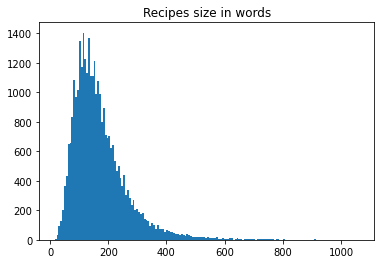

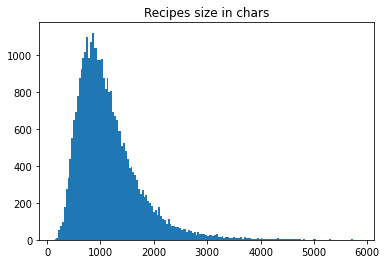

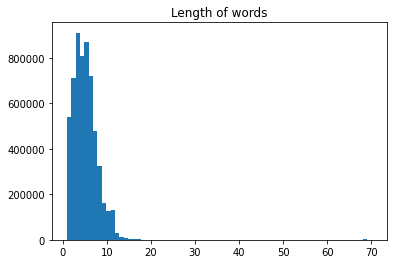

In [30]:
recipes_list = one_big_text.split("MMMMM----- Recipe via Meal-Master (tm) v8.05")
recipe_words_counter = []
recipe_chars_counter = []
for recipe in recipes_list:
    recipe_words_counter += [len(recipe.split())]
    recipe_chars_counter += [len(recipe)]
    
plt.hist(recipe_words_counter[1:], bins = int(len(recipe_words_counter)/200))
plt.title("Recipes size in words")
plt.show()

plt.hist(recipe_chars_counter[1:], bins = int(len(recipe_chars_counter)/200))
plt.title("Recipes size in chars")
plt.show()

one_big_tokens_length = []
for token in one_big_tokens:
    one_big_tokens_length.append(len(token))


plt.hist(one_big_tokens_length, bins = 70)
plt.title("Length of words")
plt.show()

Split the dataset into training, dev and test as a 80%/10%/10% split.  Provide a Python interface to access the split conveniently.

In [31]:
def recipe_list_to_dataset(l):
    return ' $RECIPE END\n'.join(itertools.chain([''], l))

split_p = (0.8, 0.1, 0.1)
split = list(itertools.accumulate((int(s*len(recipes_list)) for s in split_p)))
recipes_train, recipes_dev, recipes_test = recipes_list[:split[0]], recipes_list[split[0]:split[1]], recipes_list[split[1]:]

print("Let's see how many recipes we have in each dataset now:")
print("training:" ,len(recipes_train),"\ntest:", len(recipes_test),"\ndev:", len(recipes_dev))

Let's see how many recipes we have in each dataset now:
training: 26371 
test: 3297 
dev: 3296


In [32]:
recipes_train = recipe_list_to_dataset(recipes_train)
recipes_dev = recipe_list_to_dataset(recipes_dev)
recipes_test = recipe_list_to_dataset(recipes_test)

Choose the order of the char n-gram according to the indications given in Yoav Goldberg's article.  
Justify the choice (you should use the dev dataset for this).

<b> According to Yoav Goldberg's article, since we deal with recipes, the farther context has less meaning than if we were dealing with code for example (since then the indentations means more). This means that n-gram of about n=7 should be ideal, but we will later more n-grams between n=7 to n=8 to better choose the hype-parameter. The prodcued model won't have strong semantics of course, so we wouldn't count on the recipe producing tasty food of course. </b>

Train a char language model using your LM mode adapted to work on characters instead of words.

In [33]:
# We have implmented the language model very genericly from the beginning, 
# to still support charchter models (or any other n-gram model)
# This now make running the code for letters very simple...
lm, _ = create_lm_generic(recipes_train, order=7)

Report on the perplexity of the trained language model.  Comment on the value you observe compared to the perplexity of the word LM model obtained above.

In [34]:
print(f"Train peprlexity is {perplexity(lm, recipes_train)}")
print(f"Validation peprlexity is {perplexity(lm, recipes_dev)}")

Train peprlexity is 1.8885544163979693
Validation peprlexity is inf


<ipython-input-17-9cf6b36f5c15>:21: RuntimeWarning: overflow encountered in power
  return np.power(2, summ)


<b> We will now use Lidstone smoothing </b>

In [34]:
lind_lm, _ = create_lm_generic(recipes_train, order=7, estimator=nltk.LidstoneProbDist, gamma=0.0025, bins=len(set(list(recipes_train))))
lind_train_perp = perplexity(lind_lm, recipes_train)
lind_dev_perp = perplexity(lind_lm, recipes_dev)
print(f"Train peprlexity is {lind_train_perp}")
print(f"Validation peprlexity is {lind_dev_perp}")

Train peprlexity is 1.9209393923562852
Validation peprlexity is 2.7427429280873374


<b> Now let's find better n hyper-parameter for n-gram </b>

In [36]:
lind_lm8, _ = create_lm_generic(recipes_train, order=8, estimator=nltk.LidstoneProbDist, gamma=0.0025, bins=len(set(list(recipes_train))))
lind_train_perp = perplexity(lind_lm8, recipes_train)
lind_dev_perp = perplexity(lind_lm8, recipes_dev)
print(f"Train peprlexity is {lind_train_perp}")
print(f"Validation peprlexity is {lind_dev_perp}")

Train peprlexity is 1.800509300853822
Validation peprlexity is 2.8906118237570646


In [131]:
lind_lm6, _ = create_lm_generic(recipes_train, order=6, estimator=nltk.LidstoneProbDist, gamma=0.0025, bins=len(set(list(recipes_train))))
lind_train_perp = perplexity(lind_lm6, recipes_train)
lind_dev_perp = perplexity(lind_lm6, recipes_dev)
print(f"Train peprlexity is {lind_train_perp}")
print(f"Validation peprlexity is {lind_dev_perp}")

In [128]:
lind_lm5, _ = create_lm_generic(recipes_train, order=5, estimator=nltk.LidstoneProbDist, gamma=0.0025, bins=len(set(list(recipes_train))))
lind_train_perp = perplexity(lind_lm5, recipes_train)
lind_dev_perp = perplexity(lind_lm5, recipes_dev)
print(f"Train peprlexity is {lind_train_perp}")
print(f"Validation peprlexity is {lind_dev_perp}")

Train peprlexity is 2.3290741805693647
Validation peprlexity is 2.7653916087479424


Report on the perplexity of the trained language model.  Comment on the value you observe compared to the perplexity of the word LM model obtained above.

In [133]:
best_lm = lind_lm6
print(f"Test preprlexity is {perplexity(best_lm, recipes_test)}")

Test preprlexity is 2.637016050583145


<b> The perplexity of this model is much smaller than the one of the word LM model above. This makes sense, since the number of options for the next token is much smaller, therefor we have much greater certainty about the next token. The perplexity is very close to one, which means we should have a pretty good result when we will generate recipes </b>

Sample about 5 generated recipes from the trained language model.

In [135]:
def generate_recipes(model, seed=10, recipes=5):
    end = '$RECIPE END'
    n = len(model.conditions()[0])
    random.seed(seed)
    out = []
    for _ in range(recipes):
        hist = '*' * n
        while not hist.endswith(end) and not end.endswith(hist):
            samples = list(model[hist].samples())
            weights = []
            for s in samples:
                weights.append(model[hist].prob(s))
            token = random.choices(samples, weights=weights, k=1)
            hist = hist[1:] + token[0]
            out.append(token[0])
    return ''.join(out)

print(generate_recipes(best_lm, recipes=5))

************
      1 ts salt
  and store in the batter equal amounts of spices, Seafood, Main dish, Breads/, Yeast
      -temperature
  remove thepate one hours. Unmold onto the puree until
  minutes or pouring 194 CAL 9gm CHO 20gm PRO 8gm
  
  Trim crust. Beat until frosting.
  :      6 ts Salt
       1 ts Cinnamon candied with oil in a small squares.
         Yield: 8 Servings
 
  Mix together in a wok over hot wok. Reheat oven for 8-10
  mixture; pour over the oil in small
  nonstick sauteed manioca mixture
  the third bowl, combine mayonnaise, lemon juice
 
  Cook same
      Nutritional)
    1/4 c  Raisins.
 
MMMMM
 
      2    Habanero Hot Sauce
        1 ts Salt
          Title: BUCKEYE BEAN SOUP - MANGE (I would have the coals until frosting, sugar 2 tb.
 
MMMMM
 
  Combine flour and olive oil
  cholesterol: 0 mg Fat:
  Cover and shake gently. Refrigerator for 10 minutes, shells or bacon and pour
  about 1 hour. Rinse lentils, clean eighths. Shared by: Karin Brewer, Cookbook Dig

Write 3 to 5 observations about the generated samples.

<b> We observe that some of the generated recipes looks decent in general, they resemble the orginal recipes by their format. We do ntice that the length of the generated recipes do vary in length much more than the original ones. This is probably due to the fact the the LM does not have very long memory, and hence can wait shorter or longer before finishing (we expect the original recipes lengths to follow a Gaussian distribution, and the generated ones to follow a Geometric distribution, due to the way they were generated </b>

<hr>
<hr>
<a name="P2"></a>
<h2>Part 2: Polynomial Curve Fitting</h2>

We reproduce the polynomial curve fitting example used in Bishop's <a href="https://www.microsoft.com/en-us/research/people/cmbishop/#!prml-book">book</a> in Chapter 1.  

<a name="syntheticdata"></a>
<h3>2.1 Synthetic Dataset Generation</h3>

We generate a dataset of points in the form of 2 vectors $x$ and $t$ of size $N$ where:

$t_i = y(x_i) + \mathcal{N}(\mu, \sigma)$

where:
* The $x_i$ values are equi-distant on the $[0 \dots 1]$ segment (that is, $x_1 = 0, x_2=\frac{1}{N-1}, x_3=\frac{2}{N-1}..., x_N = 1.0$)
* $\mu = 0.0$
* $\sigma = 0.03$ 
* $y(x) = sin(2\pi \times x)$

In [45]:
# Learn the function y given the generated noisy dataset
def generateDataset(N, f, sigma):
    x = np.linspace(0.0, 1.0, num=N)
    y = f(x)
    t = y + np.random.normal(0,sigma,len(x))
    return x, t
x, t = generateDataset(100, lambda x: np.sin(2*np.pi*x), 0.03)


Draw the plot (scatterplot) of (x,t) using matplotlib for N=100.
* Look at the documentation of the <a href="https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.normal.html#numpy.random.Generator.normal">numpy.random.Generator.normal</a> function in Numpy for an example of usage.
* Look at the definition of the function <a href="https://numpy.org/doc/stable/reference/generated/numpy.linspace.html#numpy.linspace">numpy.linspace</a> to generate your dataset.


Text(0, 0.5, 't')

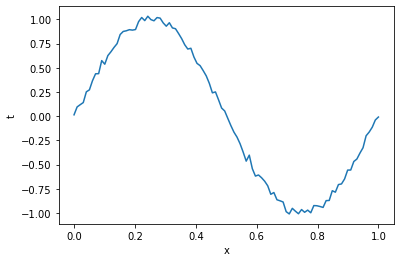

In [46]:
plt.plot(x, t)
plt.xlabel('x')
plt.ylabel('t')

In [47]:
import math
import numpy as np
def s(x): return x**2
def f(x): return math.sin(2 * math.pi * x)
vf = np.vectorize(f)        # Create a vectorized version of f

z = np.array([1,2,3,4])
print(z)

sz = s(z)                   # You can apply simple functions to an array
print(sz.shape)             # Same dimension as z (4)
print(sz)

fz = vf(z)                  # For more complex ones, you must use the vectorized version of f
print(fz.shape)
print(fz)

[1 2 3 4]
(4,)
[ 1  4  9 16]
(4,)
[-2.44929360e-16 -4.89858720e-16 -7.34788079e-16 -9.79717439e-16]


<a name="curvefitting"></a>
<h3>2.2 Polynomial Curve Fitting</h3>

We will attempt to learn the function y given a synthetic dataset $(x, t)$.

We assume that $y$ is a polynomial of degree $M$ - that is:

$y(x) = w_0 + w_1 x + w_2 x^2 + ... + w_M x^M$

Our objective is to estimate the vector $w = (w_0 \dots w_M)$ from the dataset $(x, t)$.

In [48]:
import numpy as np
import scipy.linalg

t = np.array([1,2,3,4])                    # This is a vector of dim 4
print(t.shape)                                   # (4,)
phi = np.array([[1,1],[2,4],[3,3],[2,4]])  # This is a 4x2 matrix
print(phi.shape)                                  # (4, 2) 
prod = np.dot(phi.T, phi)                  # prod is a 2x2 matrix
print(prod.shape)                                 # (2, 2)
i = np.linalg.inv(prod)                    # i is a 2x2 matrix
print(i.shape)                                    # (2, 2)
m = np.dot(i, phi.T)                       # m is a 2x4 matrix
print(m.shape)                                    # (2, 4)
w = np.dot(m, t)                           # w is a vector of dim 2
print(w.shape)                                    # (2,)

(4,)
(4, 2)
(2, 2)
(2, 2)
(2, 4)
(2,)


We implement a method <b>optimizeLS(x, t, M)</b> which given the dataset $(x, t)$ returns the optimal polynomial of degree $M$ that approximates the dataset according to the least squares objective. 

In [49]:
def optimizeLS(x, t, M):
    X = np.vander(x, M)
    XT = X.T
    return np.linalg.inv(XT.dot(X)).dot(XT).dot(t)

def test_optimizeLS():
    x = np.arange(5)
    a = [0, 2, 5, 4]
    y = a[3]*x**3 + a[2]*x**2 + a[1]*x + a[0]
    LS = optimizeLS(x, y, 4)
    np.testing.assert_allclose(LS, np.flip(a), atol=1e-5)
test_optimizeLS()
    

We now plot the learned polynomial $w_M(x_i)$ and the real function $sin(2πx)$ for a dataset of size $N=10$ and $M=1,3,5,10$.


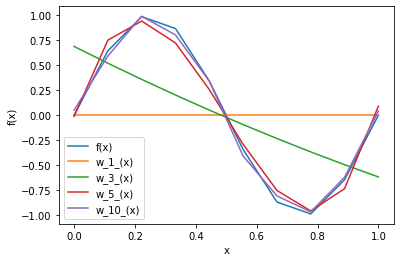

In [50]:
x, t = generateDataset(10, vf, 0.03)
plt.plot(x, vf(x), label="f(x)")
for M in [1,3,5,10]:
    w = optimizeLS(x, t, M)
    def poly(x): return np.polyval(w, x)
    vpoly = np.vectorize(poly)
    wMx = vpoly(x)
    plt.plot(x, wMx, label=f"w_{M}_(x)")
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend(loc="lower left")

<a name="regularization"></a>
<h3>2.3 Polynomial Curve Fitting with Regularization</h3>

We observe in the plot above that the solution to the least-squares optimization has a tendency to over-fit the dataset.

To avoid over-fitting, we will use <i>regularization</i>: the objective function we want to optimize will take into account the least-squares error as above, and in addition the complexity of the learned model $w$.

We write a function <b>optimizePLS(x, t, M, lambda)</b> which returns the optimal parameters $w_{PLS}$ given $M$ and $\lambda$.

In [51]:
def optimizePLS(x, t, M, lamb=0):
    X = np.vander(x, M)
    XT = X.T
    return np.linalg.inv(XT.dot(X)+ lamb*np.identity(X.shape[1])).dot(XT).dot(t)

def test_optimizePLS():
    x = np.arange(5)
    a = [0, 2, 5, 4]
    y = a[3]*x**3 + a[2]*x**2 + a[1]*x + a[0]
    PLS = optimizePLS(x, y, 4)
    np.testing.assert_allclose(PLS, np.flip(a), atol=1e-5)
test_optimizePLS()

We want to optimize the value of λ. The way to optimize is to use a development set in addition to our training set.

To construct a development set, we extend our synthetic dataset construction function to return 3 samples:
* one for training, 
* one for development 
* and one for testing

In [52]:
def generateDataset3(N, f, sigma):
    x = np.linspace(0.0, 1.0, num=3*N)
    np.random.shuffle(x)
    y = f(x)
    t = y + np.random.normal(0,sigma,len(x))
    return (x[:N], t[:N]), (x[N:2*N], t[N:2*N]), (x[2*N:], t[2*N:])

Given a synthetic dataset, we optimize for the value of λ by varying the value of log(λ) from -40 to -20 on the development set. 

1.026187963170189e-10

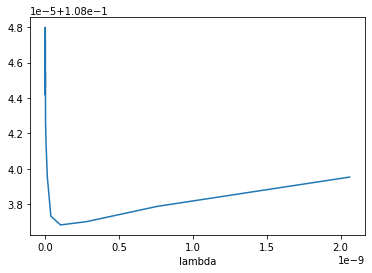

In [66]:
def NE(x, t):
    return np.power(np.sum(np.power(t-x, 2)), 0.5) / len(x)

def optimizePLS2(xt, tt, xv, tv, M, plot=True):
    loglambs = np.arange(-40, -19)
    lambs = np.exp(loglambs)
    nes = np.empty(lambs.shape)
    for i, lamb in enumerate(lambs):
        w = optimizePLS(xt, tt, M, lamb)
        def poly(x): return np.polyval(w, x)
        vpoly = np.vectorize(poly)
        wMx = vpoly(xv)
        nes[i] = NE(xv, wMx)
    if plot:
        plt.plot(lambs, nes)
        plt.xlabel('lambda')
    return lambs[np.argmin(nes)]

(xt, tt), (xv, tv), (xtest, vtest) = generateDataset3(100, vf, 0.03)
optimizePLS2(xt, tt, xv, tv, 10)    

<BarContainer object of 6 artists>

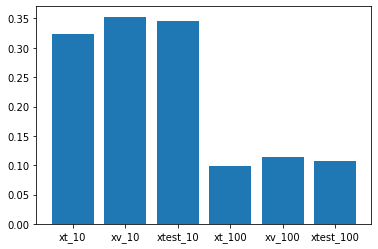

In [68]:
# Draw the plot of the normalized error of the model for the training, 
# development and test for the case of $N = 10$ and the case of $N=100$. 

#TODO: Not sure what we should plot here... There is one error in each case

M = 10
data = {}

plt.clf()
plt.plot()
for i, N in enumerate([10, 100]):
    (xt, tt), (xv, tv), (xtest, vtest) = generateDataset3(N, vf, 0.03)
    lamb = optimizePLS2(xt, tt, xv, tv, M,plot=False)
    w = optimizePLS(xt, tt, M)
    def poly(x): return np.polyval(w, x)
    vpoly = np.vectorize(poly)
    for name, x in {'xt': xt, 'xv': xv, 'xtest': xtest}.items():
        wMx = vpoly(x)
        ne = NE(x, wMx)
        data[f"{name}_{N}"] = ne
plt.bar(list(data.keys()), list(data.values()))

#### Analyze the plots

The model with N=10 is very noisy, we can't learn the underline function even with regularization (in fact it may be worse with it sometimes, since we add a degree of freedom,hence we overfit even more).

The model with N=100 is good, we get a relatively small error (about 3*sigma), and it is consistent among the train, validation and test datasets.

<a name="prob-regr"></a>
<h3>2.4 Probabilistic Regression Framework</h3>

We now consider the same problem of regression (learning a function from a dataset) formulated in a probabilistic framework.

In [69]:
def bayesianEstimator(x, t, M, alpha, sigma2):
    phi = lambda x: np.vander(x, M+1).T
    invS = alpha*np.identity(M+1) + 1/sigma2*np.sum([phi([x[i]]).dot(phi([x[i]]).T) for i in range(len(x))], 0)
    S = np.linalg.inv(invS)
    m = lambda z: 1/sigma2*phi(z).T.dot(S).dot(np.sum([phi([x[i]])*t[i] for i in range(len(x))], 0))
    s2 = lambda z: sigma2 + phi(z).T.dot(S).dot(phi(z))
    return m, s2

We draw the plot of the original function $y = sin(2πx)$ over the range $[0 \dots 1]$, the mean of the predictive distribution $m(x)$ and the confidence interval $m(x) - \sqrt{var(x)}$ and $m(x) + \sqrt{var(x)}$ (that is, one standard deviation around each predicted point) for the values:
* $\alpha = 0.005$
* $\sigma^2 = 1/11.1$
* $M = 9$

over a synthetic dataset of size $N=10$

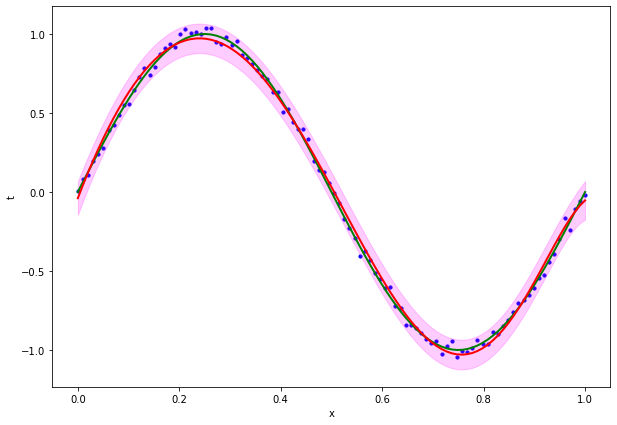

In [70]:
alpha = 0.005
sigma2 = 1/11.1
M = 9
N = 100
x, t = generateDataset(N, vf, 0.03)
m, s2 = bayesianEstimator(x,t, M, alpha, sigma2)

mx = m(x).reshape((N,))
s2x = s2(x)
cix = np.diag(s2x).reshape((N,))

## Draw the plot
def draw_prob_plot(x, t, mx, cix):
    plt.figure(figsize=(10, 7))
    plt.plot(x, vf(x), color='g', linewidth=2)
    plt.scatter(x, t, color='b', s=10)
    plt.plot(x, mx, color='r', linewidth=2)
    plt.xlabel('x')
    plt.ylabel('t')
    plt.fill_between(x, mx - cix, mx + cix, color='magenta', alpha=.2)
draw_prob_plot(x, t, mx, cix)

Now for $N=100$:

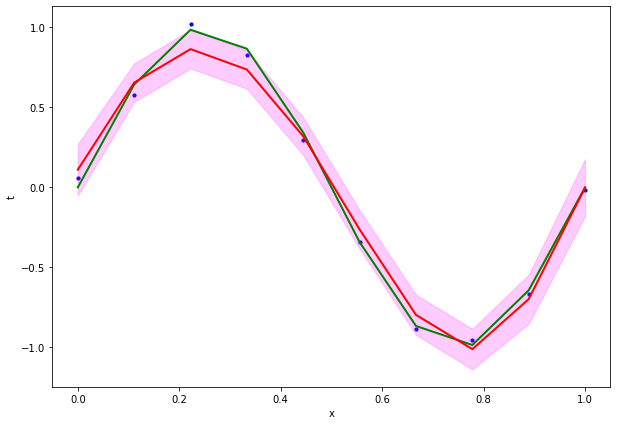

In [71]:
N = 10
x, t = generateDataset(N, vf, 0.03)
m, s2 = bayesianEstimator(x,t, M, alpha, sigma2)

mx = m(x).reshape((N,))
s2x = s2(x)
cix = np.diag(s2x).reshape((N,))

## Draw the plot
draw_prob_plot(x, t, mx, cix)

Interpret the height of the band around the most likely function in terms of the distribution of the xs in your synthetic dataset.
Can you think of ways to make this height very small in one segment of the function and large in another?

<b>The height of the band around the most likely function, is the confidence interval for each value (at 67% confidence).
A way to make this height small in one segment would be to sample more times on that segment (at the expanse of other segments</b>).
As we can see in this example, the height band around middle point is smller:

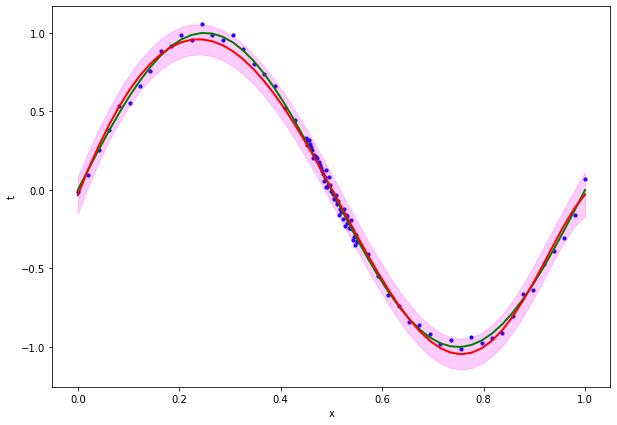

In [72]:
def generateDatasetMoreInMiddle(N, K, f, sigma):
    x = np.hstack((np.linspace(0.0, 1.0, num=N-K) , np.linspace(0.45, 0.55, num=K)))
    x = np.sort(x)
    y = f(x)
    t = y + np.random.normal(0,sigma,len(x))
    return x, t

N = 100
K = 50
x, t = generateDatasetMoreInMiddle(N, K, vf, 0.03)
m, s2 = bayesianEstimator(x,t, M, alpha, sigma2)

mx = m(x).reshape((N,))
s2x = s2(x)
cix = np.diag(s2x).reshape((N,))

## Draw the plot
draw_prob_plot(x, t, mx, cix)

<hr/>
<hr/>
<a name="P3"></a>
<h2>Part 3: Neural Models for Classification</h2>

In this section, we adopt the PyTorch tutorial on 
<a href="https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html">Character RNN for classification</a>
to a different dataset.

<a name="readtut"></a>
<h3>3.1 Summarize the Tutorial</h3>

We will show how to build and train a basic character-level RNN with the mission of word classification. This RNN gets a list of characters that represents a city's name as its input – and returns a prediction of its location (or, more accurately, the country it belongs to). To achieve that, we'll form a dictionary of countries and corresponding cities. Each letter will be encoded by a **one-hot vector** of size  `1Xnubmer_of_letters_and_delimiters`.
By doing so, we end up with Tensors representation for each word. When creating our 2 linear layers network we will use a **LogSoftmax layer** over the output to normalize it and keep the changes of the loss function, **nn.NLLLoss**, relatively small. The input, a Tensor of the current letter, together with a hidden state from the steps we already ran, will bring us the output and an up-to-date hidden state for future computations. We'll evaluate the result in a confusing matrix which will allow us to easily distinguish the places our model is more likely to recognize, and those it might confuse with others.
 
 

Let's begin with our expected output. In fact, it is a real output from the RNN code we will see here. given a name of a city, for example `Hanzhong`, [a Chinese city](https://www.google.com/maps/place/Hanzhong,+%D7%A9%D7%90%D7%90%D7%A0%D7%A9%D7%99,+%D7%A1%D7%99%D7%9F%E2%80%AD/@33.0763356,107.1750733,11z/data=!3m1!4b1!4m5!3m4!1s0x368a91403e11f95d:0x8d0bf0d548295d46!8m2!3d33.06748!4d107.023323) we chose randomly from google map, we would like our RNN to classify the city origin (the first answer is the most likely one):


    $python predict.py Hanzhong
    > Hanzhong
    (-0.70) cn
    (-1.37) in
    (-3.08) pk

We got an answer, and a correct one! Now - let's start from the beginning...


<a name="newdata"></a>
<h3>3.2 Explore City Names Dataset</h3>

We use a dataset on city names in different countries to train a classifier.

The data from <a href="cities_val.zip">cities_val.zip</a> (validation) and <a href="cities_train.zip">cities_train.zip</a> (training)
is under "../data/cities/val" and "../data/cities/train".


In [96]:

import codecs
import math
import random
import string
import time
import glob
import os
import numpy as np
from sklearn.metrics import accuracy_score

'''
Don't change these constants for the classification task.
You may use different copies for the sentence generation model.
'''
languages = ["af", "cn", "de", "fi", "fr", "in", "ir", "pk", "za"]
all_letters = string.ascii_letters + " .,;'"

import unicodedata
def findFiles(path): return glob.glob(path)

print("Here are the files we are going to work on:")
print(findFiles('../data/cities/train/*.txt'))

import unicodedata

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )
print("\n")
print("Let's process our data! first, let's understand unicodeToAscii:")
print("The word 'Ślusàrski' after unicodeToAscii is written as:", unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = codecs.open(filename, "r",encoding='utf-8', errors='ignore').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]


Here are the files we are going to work on:
['data/cities/train/ir.txt', 'data/cities/train/za.txt', 'data/cities/train/in.txt', 'data/cities/train/fi.txt', 'data/cities/train/pk.txt', 'data/cities/train/cn.txt', 'data/cities/train/fr.txt', 'data/cities/train/af.txt', 'data/cities/train/de.txt']


Let's process our data! first, let's understand unicodeToAscii:
The word 'Ślusàrski' after unicodeToAscii is written as: Slusarski



The first thing we would like to do is understand our data. We will compute some basic statistics that will give us a brighter understanding of our data.

We are using `unicodeToAscii` function [as suggested here](https://stackoverflow.com/a/518232/2809427) to make sure all the letters in our data are one of the 26 English letters, together with delimiters such as " " or ".".
 Since we work with a *Character-Level RNN* and each letter is represented by a *one-hot vector*, it has a direct impact on our vector dim (it is `1Xnumber_of_distinct_letters`). It gives our module an easier life, but we do pay a price - we lose some data in the conversion  process.

We use a dictionary  which maps each category (in our case - a country) to a list of lines (names of cities in that country) - we will use `category_lines` for that. The list `all_categories` will hold our different countries and `n_categories` will represent its length - we will need it soon.

In order to get a list of cities names which is easy to work with, we will split the names into an easy-to-process list, and then we will look at some statistics we got from our data:

Let's start with the files we are going to work with:

Number of categories: 9
Number of tokens per category: 3000
Number of characters:  298179
Number of distinct characters:  29
Average number of character per token: 11


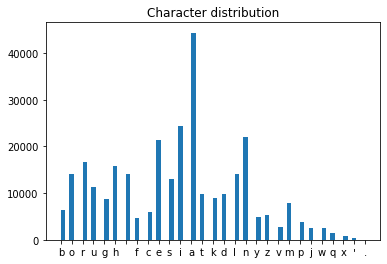

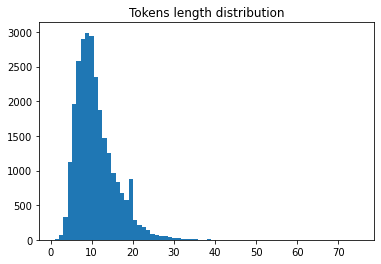

In [97]:
import matplotlib.pyplot as plt

characters = 0
one_big_line = []
summed_category_len = []

for filename in findFiles('../data/cities/train/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
    one_big_line += lines
    summed_category_len += (len(line) for line in lines)
    one_big_text = "".join(one_big_line)
    characters = len(one_big_text)


n_letters = len(all_letters)
n_categories = len(category_lines)

print("Number of categories:", n_categories)
print("Number of tokens per category:", len(summed_category_len) // n_categories)
print("Number of characters: ", characters)
print("Number of distinct characters: ", (len(set("".join(one_big_text)))))
print("Average number of character per token:", sum(summed_category_len) // (len(one_big_line)))



plt.hist(list("".join(one_big_line)), bins = 70)
plt.title("Character distribution")
plt.show()

plt.hist(summed_category_len, bins = 70)
plt.title("Tokens length distribution")
plt.show()

<a name="citiesmodel"></a>
<h3>3.3 Train a Model and Evaluate It</h3>

So now when we have a better understanding of our data, it's time to help our RNN understand it as well. To achieve that we will build a Tensor to hold our letters and words.
Let's see an example of a `letterToTensor` function which takes a letter (one of the letters in `all_letters`) and returns a Tensor representation of it as a *one-hot vector* - a vector of zeroes except a one in the element in the letter's index place, in size `<1Xn_letter>`.
A single line (one city name) will be a matrix of letters - a Tensor of size `<line_length x 1 x n_letters>`.

In [98]:
import torch 

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)


# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor


# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor


print ("Here is a Tensor of the letter 'c':")
print(letterToTensor('c'))
print()
print("Here is a Tensor of the word 'NLP':")
print(lineToTensor("NLP"))


Here is a Tensor of the letter 'c':
tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])

Here is a Tensor of the word 'NLP':
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.,

# Creating the Network

Now we can start building  our RNN module. 
As the original tutorial explains:

>_"Before autograd, creating a recurrent neural network in Torch involved
cloning the parameters of a layer over several timesteps. The layers
held hidden state and gradients which are now entirely handled by the
graph itself. This means you can implement a RNN in a very "pure" way,
as regular feed-forward layers."_



In [99]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In each step we will pass a Tensor of a letter as input, in addition to the previous hidden state. The output will be the probability  of each country to be the country this city is located in. We will use `lineToTensor` with an argument (for example `'Paris'`) and let our code do the rest:



In [100]:
input = lineToTensor('Paris')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.2593, -2.2020, -2.2694, -2.1361, -2.3074, -2.1125, -2.2542, -2.1193,
         -2.1373]], grad_fn=<LogSoftmaxBackward>)


We get a `<1 x n_categories>` Tensor with the probability of every one of our `n_categort` to be the relevent language.



# Training


For the training we will use dome helper functions suggested by [the tutorial](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html) we based on, togather with an exanple that will help us understand the process we go through:


In [101]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

print("Let's try to take some category-line (country-city name) examples:")
for i in range(5):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

Let's try to take some category-line (country-city name) examples:
category = af / line = kajdara
category = pk / line = akbruta
category = fi / line = hokkanen
category = za / line = qaryat ar ruzayqi
category = de / line = krumnussbaum an der donauuferbahn


**Now we can start the training!**

We will use again our original tutorial which gives a great and bright explainations of the process: 


>  * *Each loop of training will:*
    - *Create input and target tensors*
    - *Create a zeroed initial hidden state*
    - *Read each letter in and*
     - Keep hidden state for next letter*
    - *Compare final output to target*
    - *Back-propagate*
    - *Return the output and loss*


In [102]:
criterion = nn.NLLLoss()
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

Since the training might be confusing, a nice way to demonstrate it as it runs is to print several examples during the process:



In [103]:
import time
import math

n_iters = 17500
print_every = 500
plot_every = 200

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0



500 2% (0m 1s) 2.1568 shafrikent / fi ✗ (fr)
1000 5% (0m 2s) 2.2251 tazeh kande sheykh ol eslam / af ✗ (ir)
1500 8% (0m 3s) 2.0524 mashkun / pk ✓
2000 11% (0m 5s) 1.9872 linhu / cn ✓
2500 14% (0m 6s) 2.2598 villersletourneur / pk ✗ (fr)
3000 17% (0m 8s) 2.2155 voires / fr ✗ (ir)
3500 20% (0m 9s) 2.1977 krovino seltso / fi ✗ (in)
4000 22% (0m 10s) 2.3194 lomas del copinol / fr ✗ (de)
4500 25% (0m 12s) 2.1579 sra nawa / fi ✗ (af)
5000 28% (0m 13s) 2.1359 zangtun / cn ✗ (za)
5500 31% (0m 14s) 1.5768 fuxingcun / cn ✓
6000 34% (0m 16s) 2.2021 dzheirli / fi ✗ (ir)
6500 37% (0m 17s) 2.0551 kafin wamba / pk ✗ (fi)
7000 40% (0m 18s) 1.9562 thatta makhdumpur / pk ✓
7500 42% (0m 19s) 1.8851 monadelan / ir ✓
8000 45% (0m 21s) 1.1489 tjisingdang / cn ✗ (in)
8500 48% (0m 22s) 2.0386 tegerbari / de ✗ (ir)
9000 51% (0m 23s) 2.7647 shabaopo / za ✗ (cn)
9500 54% (0m 25s) 1.6290 kousaniemi / fi ✓
10000 57% (0m 26s) 1.3022 xilinji / cn ✓
10500 60% (0m 27s) 1.7425 dashtol / af ✓
11000 62% (0m 29s) 0.4949 g

A beautiful way to organize our result is **confusion matrix**. It shows us, for every country, what was the module guesses and indicates (in yellow) a high probability guess. We can easily understand what are the languages our module deals with successfully, and which languages confused it. 
We can learn a lot by looking at this matrix - we will discuss it later.
Besides, we will build a graph to represent the changes that occur in the `all_losses`, and hopefully, we will be able to see how it approaches one.


In [106]:
all_categories

[]

<ipython-input-107-2e96c20fa56a>:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-107-2e96c20fa56a>:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


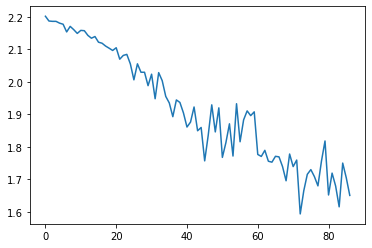

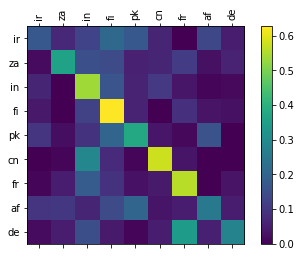

In [107]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
category_lines = {}
all_categories = []
for filename in findFiles('../data/cities/val/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
    
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)


# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()


Let's have a look at several confusion matrixes, results of running this code several times (with minor changes in the number of the iteration - around 15,000 to 20,000).

Here are some outputs we got for different random seeds:

![asd](https://i.ibb.co/Q9pnkYg/myplots.png)

Our eyes can immediately spot the country that our module easily recognize - China. It might be the major differences or several character sequences that can only be found there, but for a fact, it was successfully guessed.
Along the main axis, we see that most countries are spotted correctly, but the color is not as bright as we would have wanted, indicating a probability that is not very high compared to other countries.
It tends to confuse Afghanistan with Pakistan - a reasonable mistake.

While we do recognize a clear main axis, it is not as good as we would have wanted. Turns out that besides the quality of the module, we must understand **the quality of the data** we work with. Our data, the cities list, contains some cities which do not belong to the country they appear to be located in. 
For example, if we look at the file "de" (Germany), we can spot cities from Spain, England, Afghanistan, Pakistan, etc. This is an outcome of the way the data was collected. People in several countries were asked what is their **city of birth**. Since not all Germans were born in Germany, the list includes cities around the world.

It is a good example of the importance of not only get the raw data but understand exactly how it was collected - what were the questions this data is answering.




## Back to our example from the beginning

As you may remember, we began with this:

    $python predict.py Hanzhong
    > Hanzhong
    (-0.70) cn
    (-1.37) in
    (-3.08) pk
    
Now let's see it heppenning! 

In [108]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])




Now let's give our module to check these cities, randomly chosen from google map:

[Aschberg](https://www.google.com/maps/place/08248+Aschberg,+%D7%92%D7%A8%D7%9E%D7%A0%D7%99%D7%94%E2%80%AD/@50.3899751,12.5080553,15z/data=!3m1!4b1!4m13!1m7!3m6!1s0x47a0dd32da4618d3:0xa21b1cdd6774c80!2zS290dGVuaGVpZGUsIDA4MjYxIFNjaMO2bmVjaywg15LXqNee16DXmdeU!3b1!8m2!3d50.3784944!4d12.4004348!3m4!1s0x47a0c3c5e09e52e1:0xa21b1cdd677d7d0!8m2!3d50.3899704!4d12.4993086) - a small place in Germany.

[Dera Allah Yar](https://www.google.com/maps/place/Dera+Allah+Yar,+Jaffarabad,+%D7%91%D7%9C%D7%95%D7%A6'%D7%99%D7%A1%D7%98%D7%9F,+%D7%A4%D7%A7%D7%99%D7%A1%D7%98%D7%9F%E2%80%AD/@27.3379469,68.3414802,6.07z/data=!4m13!1m7!3m6!1s0x47a0dd32da4618d3:0xa21b1cdd6774c80!2zS290dGVuaGVpZGUsIDA4MjYxIFNjaMO2bmVjaywg15LXqNee16DXmdeU!3b1!8m2!3d50.3784944!4d12.4004348!3m4!1s0x393477e237294b09:0x6de34fb11c624bad!8m2!3d28.3744855!4d68.3486938) - a town in the middle of Pakistan.

[Jinchang](https://www.google.com/maps/place/Jinchang,+%D7%92%D7%90%D7%A0%D7%A1%D7%95,+%D7%A1%D7%99%D7%9F%E2%80%AD/@40.5962792,110.0647365,5.21z/data=!4m13!1m7!3m6!1s0x47a0dd32da4618d3:0xa21b1cdd6774c80!2zS290dGVuaGVpZGUsIDA4MjYxIFNjaMO2bmVjaywg15LXqNee16DXmdeU!3b1!8m2!3d50.3784944!4d12.4004348!3m4!1s0x36496462b5f15307:0xad78bf2cd23f56ad!8m2!3d38.5201009!4d102.1879578) - a Chinese village near the border with Mongolyia.


In [109]:
predict('Aschberg')
predict('Dera Allah Yar')
predict('Jinchang')


> Aschberg
(-1.09) de
(-1.57) fr
(-2.34) in

> Dera Allah Yar
(-1.21) pk
(-1.32) af
(-1.41) ir

> Jinchang
(-0.58) cn
(-1.16) in
(-3.24) fi


<a name="bettercitiesmodel"></a>
<h3>3.4 Improve the RNN Model (Optional)</h3>



<b> We've tried to improve our result by changing 3 parameters - `n_iters`, `learning_rate`, and  `n_hidden`. We also tried to start with random value instead of zero in the hidden state.
The results has never improved significantly. Perhaps a more systematic hyper-parameter search using hyperopt or another hyper paramerer optimization library would produce better results. </b>